## Importing Libraries

In [3]:
!pip install py_vollib
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as si
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega

zsh:1: command not found: pip


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from datetime import datetime

## Defining functions for Implied Volatility and VEGA

In [6]:
def norm(x):
    norm = si.norm.cdf(x,0.0,1.0)
    return(norm)

In [7]:
def BlackScholesCall(S,X,r,T,σ):
    d1 = ( (np.log(S/X)+(r+0.5*σ**2)*T) / (σ*np.sqrt(T)) )
    d2 = ( (np.log(S/X)+(r-0.5*σ**2)*T) / (σ*np.sqrt(T)) )
    BlackScholesCall = S*norm(d1) - X*np.exp(-r*T)*norm(d2)
    return (BlackScholesCall)

In [8]:
def BlackScholesPut(S,X,r,T,σ):
    d1 = ( (np.log(S/X)+(r+0.5*σ**2)*T) / (σ*np.sqrt(T)) )
    d2 = ( (np.log(S/X)+(r-0.5*σ**2)*T) / (σ*np.sqrt(T)) )
    BlackScholesPut = X*np.exp(-r*T)*norm(-d2) - S*norm(-d1)
    return (BlackScholesPut)

In [9]:
def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Compute the implied volatility of a European Option
        S0: stock price
        K:  strike price
        T:  time to maturity
        r:  risk-free rate
        market_price: option price
        tol: user choosen tolerance
    """
    max_iter = 200 #max number of iterations
    vol_old = 0.30 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime =  vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        bs_new = bs(flag, S0, K, T, r, vol_new)

        if (abs(vol_old - vol_new) < tol or abs(bs_new - market_price) < tol):
            break
        vol_old = vol_new

    implied_vol = vol_old
    return implied_vol

In [10]:
def implied_vol_percentile(obj,i):
  t=i-1
  count=0
  while(t>=0):
      if(obj['iv'].iloc[i]>obj['iv'].iloc[t]):
          count+=1
  return (count/(i-1))

In [11]:
def change_type_date(stock):
    for i in range(len(stock['Date'])):
        obj=datetime.strptime(stock['Date'].iloc[i],'%a %b %d %Y %H:%M:%S GMT%z (India Standard Time)')
        stock['Date'].iloc[i]=obj.strftime("%Y-%m-%d %H:%M:%S")
    return stock

In [12]:
def diff_dates(dt1,dt2):
    # Parse the dates
    date1 = datetime.strptime(dt1, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.strptime(dt2, "%Y-%m-%d %H:%M:%S")

    difference_in_days = (date2 - date1).days


    difference_in_years = difference_in_days / 365.25  # Accounting for leap years

    return difference_in_years

In [13]:
#data

#data=pd.read_csv('./NIFTY 16th MAY 22200 CE.csv')
#data_put=pd.read_csv('./NIFTY 16th MAY 22200 PE.csv')
stock=pd.read_csv('./NIFTY 50 stock data.csv')


In [14]:
stock=change_type_date(stock)
stock=stock.set_index('Date')
stock

,Open,High,Low,Close,"Trend ‌Supertrend‌ (7,3)"
Date,,,,,
2024-05-09 10:00:00,22219.80,22231.35,22209.85,22221.40,22317.55
2024-05-09 10:05:00,22222.75,22237.15,22219.75,22229.25,22317.55
2024-05-09 10:10:00,22230.10,22234.85,22188.35,22194.40,22309.15
2024-05-09 10:15:00,22194.40,22210.25,22184.00,22200.00,22291.99
2024-05-09 10:20:00,22200.05,22201.20,22151.60,22151.60,22278.97
...,...,...,...,...,...
2024-05-14 15:05:00,22203.55,22223.80,22198.45,22222.45,22272.40
2024-05-14 15:10:00,22222.65,22228.35,22218.70,22222.05,22272.40
2024-05-14 15:15:00,22221.10,22226.95,22217.25,22220.65,22272.40


In [18]:
#data.index

In [23]:
def IVper(data):
    percentiles=[0]
    from scipy.stats import percentileofscore
    for i in range(len(data['iv'])):
        if(i!=0):
            if(i>=0 and i<66):
                percentiles.append(percentileofscore(data['iv'][0:i], data['iv'][i]))
            if(i>=66 and i<141):
                percentiles.append(percentileofscore(data['iv'][66:i], data['iv'][i]))
            if(i>=141 and i<216):
                percentiles.append(percentileofscore(data['iv'][141:i], data['iv'][i]))
            if(i>=216 and i<291):
                percentiles.append(percentileofscore(data['iv'][216:i], data['iv'][i]))
    append_df=pd.Series(percentiles,index=data.index)
    data['IVper']=append_df
    return data

In [27]:
def vegacal(data,type):
    list_vega=[]
    for i in range(len(data['Close'])):
        vega_val=vega( type,data['spot'].iloc[i], 22200,data['T'].iloc[i] , 0.04, data['iv'].iloc[i])
        list_vega.append(vega_val)

    append_df=pd.Series(list_vega,index=data.index)
    data['vega']=append_df
    return data


In [31]:
def create_iv_ivper_vega(obj,type):
    obj=change_type_date(obj)
    obj=obj.set_index('Date')
    obj['spot']=stock['Close']
    list_ans=[]
    for i in obj.index:
        x=diff_dates(i,'2024-05-16 10:00:00')
        list_ans.append(x)

    append_df=pd.Series(list_ans,index=obj.index)
    obj['T']=append_df
    list_iv=[]
    for i in range(len(obj['Close'])):
        impliedvol=implied_vol(obj['spot'].iloc[i],22200,obj['T'].iloc[i],0.02,obj['Close'].iloc[i],flag=type)
        list_iv.append(impliedvol)
    iv=pd.Series(list_iv,index=obj.index)
    obj['iv']=iv
    obj=IVper(obj)
    obj=vegacal(obj,type)
    return obj

## Strategy

In [32]:
call_data=[]
put_data=[]
for i in range(21850,22350,50):
    call=pd.read_csv(f'./NIFTY 16th MAY {i} CE.csv')
    put=pd.read_csv(f'./NIFTY 16th MAY {i} PE.csv')
    call_data.append(create_iv_ivper_vega(call,'c'))
    put_data.append(create_iv_ivper_vega(put,'p'))

In [33]:
stock

,Open,High,Low,Close,"Trend ‌Supertrend‌ (7,3)"
Date,,,,,
2024-05-09 10:00:00,22219.80,22231.35,22209.85,22221.40,22317.55
2024-05-09 10:05:00,22222.75,22237.15,22219.75,22229.25,22317.55
2024-05-09 10:10:00,22230.10,22234.85,22188.35,22194.40,22309.15
2024-05-09 10:15:00,22194.40,22210.25,22184.00,22200.00,22291.99
2024-05-09 10:20:00,22200.05,22201.20,22151.60,22151.60,22278.97
...,...,...,...,...,...
2024-05-14 15:05:00,22203.55,22223.80,22198.45,22222.45,22272.40
2024-05-14 15:10:00,22222.65,22228.35,22218.70,22222.05,22272.40
2024-05-14 15:15:00,22221.10,22226.95,22217.25,22220.65,22272.40


In [34]:
def macd(data):
    data['MACD'] = data['Close'].ewm(span = 12,adjust=False).mean() - data['Close'].ewm(span=28,adjust=False).mean()
    data['Signal_MACD'] = data['MACD'].ewm(span = 9,adjust = False).mean()
    return data

stock = macd(stock)

stock ['IBS'] = (stock['Close'] - stock['Low']) /(stock['High'] - stock['Low'])
stock['weight_avg'] = stock['IBS'].ewm(span=5,adjust=True).mean()
stock

,Open,High,Low,Close,"Trend ‌Supertrend‌ (7,3)",MACD,Signal_MACD,IBS,weight_avg
Date,,,,,,,,,
2024-05-09 10:00:00,22219.80,22231.35,22209.85,22221.40,22317.55,0.000000,0.000000,0.537209,0.537209
2024-05-09 10:05:00,22222.75,22237.15,22219.75,22229.25,22317.55,0.666313,0.133263,0.545977,0.542470
2024-05-09 10:10:00,22230.10,22234.85,22188.35,22194.40,22309.15,-1.773927,-0.248175,0.130108,0.347140
2024-05-09 10:15:00,22194.40,22210.25,22184.00,22200.00,22291.99,-3.202190,-0.838978,0.609524,0.456130
2024-05-09 10:20:00,22200.05,22201.20,22151.60,22151.60,22278.97,-8.401621,-2.351507,0.000000,0.281028
...,...,...,...,...,...,...,...,...,...
2024-05-14 15:05:00,22203.55,22223.80,22198.45,22222.45,22272.40,5.157878,12.016691,0.946746,0.570987
2024-05-14 15:10:00,22222.65,22228.35,22218.70,22222.05,22272.40,3.839232,10.381199,0.347150,0.496375
2024-05-14 15:15:00,22221.10,22226.95,22217.25,22220.65,22272.40,2.640837,8.833127,0.350515,0.447755


In [35]:
stock['signals'] = 0
for i in range(1,len(stock)):
    if(stock['weight_avg'][i-1]>0.7 and (stock.MACD[i] > stock.Signal_MACD[i])):
        stock.signals[i] = 1
    elif(stock['weight_avg'][i-1]<0.3 and (stock.MACD[i] < stock.Signal_MACD[i])):
        stock.signals[i] = -1

stock

,Open,High,Low,Close,"Trend ‌Supertrend‌ (7,3)",MACD,Signal_MACD,IBS,weight_avg,signals
Date,,,,,,,,,,
2024-05-09 10:00:00,22219.80,22231.35,22209.85,22221.40,22317.55,0.000000,0.000000,0.537209,0.537209,0
2024-05-09 10:05:00,22222.75,22237.15,22219.75,22229.25,22317.55,0.666313,0.133263,0.545977,0.542470,0
2024-05-09 10:10:00,22230.10,22234.85,22188.35,22194.40,22309.15,-1.773927,-0.248175,0.130108,0.347140,0
2024-05-09 10:15:00,22194.40,22210.25,22184.00,22200.00,22291.99,-3.202190,-0.838978,0.609524,0.456130,0
2024-05-09 10:20:00,22200.05,22201.20,22151.60,22151.60,22278.97,-8.401621,-2.351507,0.000000,0.281028,0
...,...,...,...,...,...,...,...,...,...,...
2024-05-14 15:05:00,22203.55,22223.80,22198.45,22222.45,22272.40,5.157878,12.016691,0.946746,0.570987,0
2024-05-14 15:10:00,22222.65,22228.35,22218.70,22222.05,22272.40,3.839232,10.381199,0.347150,0.496375,0
2024-05-14 15:15:00,22221.10,22226.95,22217.25,22220.65,22272.40,2.640837,8.833127,0.350515,0.447755,0


In [36]:
len(call_data)

10

In [95]:
call_data[0]

,Open,High,Low,Close,Volume,OI,"Trend ‌Supertrend‌ (7,3)",spot,T,iv,IVper,vega
Date,,,,,,,,,,,,
2024-05-09 10:00:00,457.00,457.00,445.35,445.35,175.0,5375.0,489.90,22221.40,0.019165,0.350836,0.000000,12.250565
2024-05-09 10:05:00,445.35,459.35,445.35,459.35,100.0,5475.0,489.90,22229.25,0.016427,0.388222,100.000000,11.342550
2024-05-09 10:10:00,459.35,459.35,431.00,434.00,450.0,5675.0,489.90,22194.40,0.016427,0.381735,50.000000,11.342304
2024-05-09 10:15:00,434.00,439.05,432.55,439.05,200.0,6025.0,477.79,22200.00,0.016427,0.383663,66.666667,11.343076
2024-05-09 10:20:00,439.05,439.05,394.50,394.50,2500.0,8025.0,471.86,22151.60,0.016427,0.365864,25.000000,11.326031
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-14 15:05:00,371.00,398.00,371.00,398.00,2350.0,302900.0,447.55,22222.45,0.002738,0.833470,74.285714,4.633585
2024-05-14 15:10:00,398.00,403.60,395.00,398.20,2900.0,302425.0,447.55,22222.05,0.002738,0.834324,74.647887,4.633592
2024-05-14 15:15:00,398.20,398.75,394.80,397.50,1025.0,302450.0,447.55,22220.65,0.002738,0.834289,73.611111,4.633610


## IMPLIED VOLATILITY GRAPHS 

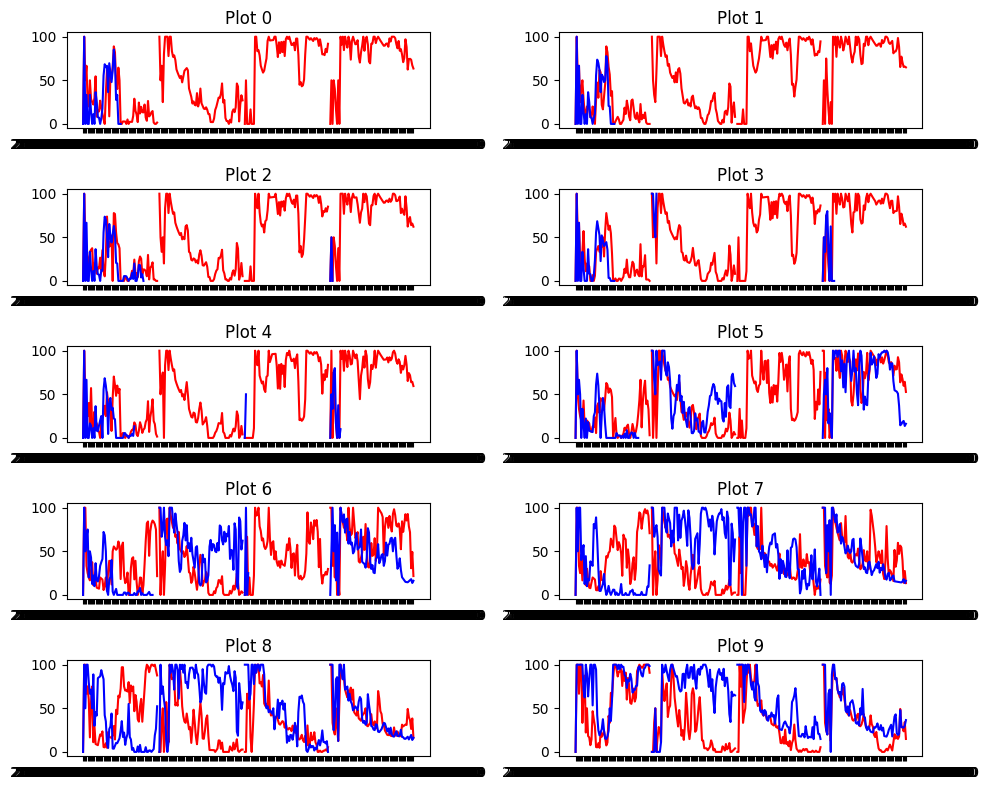

In [99]:
fig, axs = plt.subplots(5, 2, figsize=(10, 8))
counter=0
# Looping through each subplot and plotting data
for i in range(5):
    for j in range(2):
        ax = axs[i, j]
        ax.plot(call_data[counter].index.values, call_data[counter]['IVper'],c='r')
        ax.plot(put_data[counter].index.values, put_data[counter]['IVper'],c='b')
        ax.set_title(f'Plot {counter}')
        #ax.grid(True)
        counter+=1

plt.tight_layout()
plt.show()

## OPTIONS STRATEGIES

In [39]:
day_wise=[(0,66),(66,141),(141,216),(216,291)]

In [40]:
def long_straddle(data,start,day_end, sl=0.2, tp=0.4,):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG
    option_strike = round(stock['Close'].iloc[i]/50)*50
    df_call = pd.read_csv(f"./NIFTY 16th MAY {option_strike} CE.csv")
    df_put = pd.read_csv(f"./NIFTY 16th MAY {option_strike} PE.csv")
    while (i < day_end):
        if(flag==0):
            buy=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            take_p=(1+tp)*buy
            stop_l=(1-sl)*buy
            flag=1#ACTIVE TRADE
        elif(flag==1):
            latest_close = df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            if(latest_close >take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=sell-buy
                break
            elif(latest_close <stop_l):
                sell=latest_close
                flag=-1
                profit=sell-buy
                break

        i+=1
    if(flag==1):
        sell=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
        profit=sell-buy
    return profit

In [41]:
def short_straddle(data,start,day_end, sl=0.2, tp=0.4,):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0     #START FLAG
    option_strike = round(stock['Close'].iloc[i]/50)*50
    df_call = pd.read_csv(f"./NIFTY 16th MAY {option_strike} CE.csv")
    df_put = pd.read_csv(f"./NIFTY 16th MAY {option_strike} PE.csv")
    while (i < day_end):
        if(flag==0):
            buy=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            take_p=(1-tp)*buy
            stop_l=(1+sl)*buy
            flag=1#ACTIVE TRADE
        elif(flag==1):
            latest_close = df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            if(latest_close <take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=buy-sell
                break
            elif(latest_close >stop_l):
                sell=latest_close
                flag=-1
                profit=buy-sell
                break

        i+=1
    if(flag==1):
        sell=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
        profit=buy-sell
    return profit

In [48]:
def long_strangle(data,start,day_end, sl=0.2, tp=0.4,):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG

    option_strike_call = math.ceil(stock['Close'].iloc[i]/50)*50
    if(option_strike_call>22300 or option_strike_call<21850):
      return
    df_call = pd.read_csv(f"./NIFTY 16th MAY {option_strike_call} CE.csv")
    option_strike_put = math.floor(stock['Close'].iloc[i]/50)*50
    if(option_strike_put>22300 or option_strike_put<21850):
      return
    df_put = pd.read_csv(f"./NIFTY 16th MAY {option_strike_put} PE.csv")

    while (i < day_end):
        if(flag==0):
            buy=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            take_p=(1+tp)*buy
            stop_l=(1-sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close = df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            if(latest_close >take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=sell-buy
                break
            elif(latest_close <stop_l):
                sell=latest_close
                flag=-1
                profit=sell-buy
                break

        i+=1
    if(flag==1):
        sell=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
        profit=sell-buy
    return profit

In [49]:
def short_strangle(data,start,day_end, sl=0.2, tp=0.4):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0      #START FLAG

    option_strike_call = math.ceil(stock['Close'].iloc[i]/50)*50
    if(option_strike_call>22300 or option_strike_call<21850):
      return
    df_call = pd.read_csv(f"./NIFTY 16th MAY {option_strike_call} CE.csv")
    option_strike_put = math.floor(stock['Close'].iloc[i]/50)*50
    if(option_strike_put>22300 or option_strike_put<21850):
      return
    df_put = pd.read_csv(f"./NIFTY 16th MAY {option_strike_put} PE.csv")

    while (i < day_end):
        if(flag==0):
            buy=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            take_p=(1-tp)*buy
            stop_l=(1+sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close = df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
            if(latest_close <take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=buy-sell
                break
            elif(latest_close >stop_l):
                sell=latest_close
                flag=-1
                profit=buy-sell
                break

        i+=1
    if(flag==1):
        sell=df_call['Close'].iloc[i]+df_put['Close'].iloc[i]
        profit=buy-sell
    return profit

In [50]:
#use when slightly bullish market
def ratio_spread_call(data,start,day_end, sl=0.4, tp=0.2):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG

    option_strike_long = math.ceil(stock['Close'].iloc[i]/50)*50
    if(option_strike_long>22300 or option_strike_long<21850):
      return
    df_long = pd.read_csv(f"./NIFTY 16th MAY {option_strike_long} CE.csv")
    option_strike_short = math.ceil(stock['Close'].iloc[i]/50)*50 + 50
    if(option_strike_short>22300 or option_strike_short<21850):
      return
    df_short = pd.read_csv(f"./NIFTY 16th MAY {option_strike_short} CE.csv")

    while (i < day_end):
        if(flag==0):
            buy= -df_long['Close'].iloc[i] + 2*df_short['Close'].iloc[i]
            take_p=(1-tp)*buy
            stop_l=(1+sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close = -df_long['Close'].iloc[i]+2*df_short['Close'].iloc[i]
            if(latest_close <take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=buy-sell
                break
            elif(latest_close > stop_l):
                sell = latest_close
                flag=-1
                profit=buy-sell
                break

        i+=1
    if(flag==1):
        sell= -df_long['Close'].iloc[i] + 2*df_short['Close'].iloc[i]
        profit=buy-sell
    return profit

In [51]:
#use when slightly bearish market
def ratio_spread_put(data,start,day_end, sl=0.4, tp=0.2):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG

    option_strike_long = math.floor(stock['Close'].iloc[i]/50)*50
    if(option_strike_long>22300 or option_strike_long<21850):
      return
    df_long = pd.read_csv(f"./NIFTY 16th MAY {option_strike_long} PE.csv")
    option_strike_short = math.floor(stock['Close'].iloc[i]/50)*50 - 50
    if(option_strike_short>22300 or option_strike_short<21850):
      return
    df_short = pd.read_csv(f"./NIFTY 16th MAY {option_strike_short} PE.csv")

    while (i < day_end):
        if(flag==0):
            buy= -df_long['Close'].iloc[i] + 2*df_short['Close'].iloc[i]
            take_p=(1-tp)*buy
            stop_l=(1+sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close = -df_long['Close'].iloc[i]+2*df_short['Close'].iloc[i]
            if(latest_close <take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=buy-sell
                break
            elif(latest_close > stop_l):
                sell = latest_close
                flag=-1
                profit=buy-sell
                break

        i+=1
    if(flag==1):
        sell= -df_long['Close'].iloc[i] + 2*df_short['Close'].iloc[i]
        profit=buy-sell
    return profit

In [71]:
def butterfly_long_call(data,start,day_end,sl=0.4,tp=0.2):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG

    option_strike= math.floor(stock['Close'].iloc[i]/50)*50
    if(option_strike>22300 or option_strike<21850):
      return
    df_call= pd.read_csv(f"./NIFTY 16th MAY {option_strike} CE.csv")
    option_strike_less = math.floor(stock['Close'].iloc[i]/50)*50 - 50
    if(option_strike_less>22300 or option_strike_less<21850):
      return
    df_put_less = pd.read_csv(f"./NIFTY 16th MAY {option_strike_less} CE.csv")
    option_strike_more = math.floor(stock['Close'].iloc[i]/50)*50 + 50
    if(option_strike_more>22300 or option_strike_more<21850):
      return
    df_put_more = pd.read_csv(f"./NIFTY 16th MAY {option_strike_more} CE.csv")
    

    while (i < day_end):
        if(flag==0):
            buy= -2*df_call['Close'].iloc[i] + df_put_more['Close'].iloc[i] +df_put_less['Close'].iloc[i]
            take_p=(1+tp)*buy
            stop_l=(1-sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close =  -2*df_call['Close'].iloc[i] + df_put_more['Close'].iloc[i] +df_put_less['Close'].iloc[i]
            if(latest_close >take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=sell-buy
                break
            elif(latest_close < stop_l):
                sell = latest_close
                flag=-1
                profit=sell-buy
                break

        i+=1
    if(flag==1):
        sell=  -2*df_call['Close'].iloc[i] + df_put_more['Close'].iloc[i] +df_put_less['Close'].iloc[i]
        profit=sell - buy
    return profit
    

In [72]:
def butterfly_short_call(data,start,day_end,sl=0.4,tp=0.2):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG

    option_strike= math.floor(stock['Close'].iloc[i]/50)*50
    if(option_strike>22300 or option_strike<21850):
      return
    df_call= pd.read_csv(f"./NIFTY 16th MAY {option_strike} CE.csv")
    option_strike_less = math.floor(stock['Close'].iloc[i]/50)*50 - 50
    if(option_strike_less>22300 or option_strike_less<21850):
      return
    df_call_less = pd.read_csv(f"./NIFTY 16th MAY {option_strike_less} CE.csv")
    option_strike_more = math.floor(stock['Close'].iloc[i]/50)*50 + 50
    if(option_strike_more>22300 or option_strike_more<21850):
      return
    df_call_more = pd.read_csv(f"./NIFTY 16th MAY {option_strike_more} CE.csv")
    

    while (i < day_end):
        if(flag==0):
            buy= 2*df_call['Close'].iloc[i] - df_call_more['Close'].iloc[i] - df_call_less['Close'].iloc[i]
            take_p=(1-tp)*buy
            stop_l=(1+sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close =  2*df_call['Close'].iloc[i] - df_call_more['Close'].iloc[i] - df_call_less['Close'].iloc[i]
            if(latest_close < take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=buy-sell
                break
            elif(latest_close > stop_l):
                sell = latest_close
                flag=-1
                profit=buy-sell
                break

        i+=1
    if(flag==1):
        sell=  2*df_call['Close'].iloc[i] -df_call_more['Close'].iloc[i] -df_call_less['Close'].iloc[i]
        profit=buy-sell
    return profit
    

In [81]:
def butterfly_long_put(data,start,day_end,sl=0.4,tp=0.2):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG

    option_strike= math.floor(stock['Close'].iloc[i]/50)*50
    if(option_strike>22300 or option_strike<21850):
      return
    df_call= pd.read_csv(f"./NIFTY 16th MAY {option_strike} PE.csv")
    option_strike_less = math.floor(stock['Close'].iloc[i]/50)*50 - 50
    if(option_strike_less>22300 or option_strike_less<21850):
      return
    df_put_less = pd.read_csv(f"./NIFTY 16th MAY {option_strike_less} PE.csv")
    option_strike_more = math.floor(stock['Close'].iloc[i]/50)*50 + 50
    if(option_strike_more>22300 or option_strike_more<21850):
      return
    df_put_more = pd.read_csv(f"./NIFTY 16th MAY {option_strike_more} PE.csv")
    

    while (i < day_end):
        if(flag==0):
            buy= -2*df_call['Close'].iloc[i] + df_put_more['Close'].iloc[i] +df_put_less['Close'].iloc[i]
            take_p=(1+tp)*buy
            stop_l=(1-sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close =  -2*df_call['Close'].iloc[i] + df_put_more['Close'].iloc[i] +df_put_less['Close'].iloc[i]
            if(latest_close >take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=sell-buy
                break
            elif(latest_close < stop_l):
                sell = latest_close
                flag=-1
                profit=sell-buy
                break

        i+=1
    if(flag==1):
        sell=  -2*df_call['Close'].iloc[i] + df_put_more['Close'].iloc[i] +df_put_less['Close'].iloc[i]
        profit=sell - buy
    return profit

In [82]:
def butterfly_short_put(data,start,day_end,sl=0.4,tp=0.2):
    profit=0
    buy=0
    sell=0
    i = start
    flag=0#START FLAG

    option_strike= math.floor(stock['Close'].iloc[i]/50)*50
    if(option_strike>22300 or option_strike<21850):
      return
    df_call= pd.read_csv(f"./NIFTY 16th MAY {option_strike} PE.csv")
    option_strike_less = math.floor(stock['Close'].iloc[i]/50)*50 - 50
    if(option_strike_less>22300 or option_strike_less<21850):
      return
    df_call_less = pd.read_csv(f"./NIFTY 16th MAY {option_strike_less} PE.csv")
    option_strike_more = math.floor(stock['Close'].iloc[i]/50)*50 + 50
    if(option_strike_more>22300 or option_strike_more<21850):
      return
    df_call_more = pd.read_csv(f"./NIFTY 16th MAY {option_strike_more} PE.csv")
    

    while (i < day_end):
        if(flag==0):
            buy= 2*df_call['Close'].iloc[i] - df_call_more['Close'].iloc[i] - df_call_less['Close'].iloc[i]
            take_p=(1-tp)*buy
            stop_l=(1+sl)*buy
            flag=1  #ACTIVE TRADE
        elif(flag==1):
            latest_close =  2*df_call['Close'].iloc[i] - df_call_more['Close'].iloc[i] - df_call_less['Close'].iloc[i]
            if(latest_close < take_p):
                sell=latest_close
                flag=-1#Trade Closed
                profit=buy-sell
                break
            elif(latest_close > stop_l):
                sell = latest_close
                flag=-1
                profit=buy-sell
                break

        i+=1
    if(flag==1):
        sell=  2*df_call['Close'].iloc[i] -df_call_more['Close'].iloc[i] -df_call_less['Close'].iloc[i]
        profit=buy-sell
    return profit

## BACKTESTING STRATEGIES

#### Long Strangle

In [73]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]>50):
            if(i<66 and i>2):
                pnl=long_strangle(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
                 pnl=long_strangle(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
                pnl=long_strangle(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
                pnl=long_strangle(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))


189.60000000000133
99


#### Short Strangle

In [74]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]<50):
            if(i<66 and i>2):
                pnl=short_strangle(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
                 pnl=short_strangle(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
                pnl=short_strangle(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
                pnl=short_strangle(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))


309.5499999999986
173


#### Short Straddle

In [75]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]<50):
            if(i<66 and i>2):
                pnl=short_straddle(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
                 pnl=short_straddle(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
                pnl=short_straddle(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
                pnl=short_straddle(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))

353.9499999999997
174


#### Long Straddle

In [76]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]>50):
            if(i<66 and i>2):
                pnl=long_straddle(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
                 pnl=long_straddle(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
                pnl=long_straddle(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
                pnl=long_straddle(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))

497.3500000000007
102


#### Ratio Spread Put

In [77]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]<50):
            if(i<66 and i>2):
              if(stock['signals'].iloc[i]==-1):
                pnl=ratio_spread_put(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
              if(stock['signals'].iloc[i]==-1):
                 pnl=ratio_spread_put(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
              if(stock['signals'].iloc[i]==-1):
                pnl=ratio_spread_put(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
              if(stock['signals'].iloc[i]==-1):
                pnl=ratio_spread_put(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))
fin_pnl

146.6000000000001
15


[21.200000000000003,
 -30.25,
 -22.899999999999977,
 -5.099999999999994,
 -15.25,
 7.0,
 22.500000000000014,
 23.34999999999998,
 22.750000000000014,
 19.450000000000017,
 22.450000000000017,
 23.300000000000026,
 15.549999999999997,
 22.94999999999999,
 19.600000000000023]

#### Ratio Spread Call

In [78]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]<50):
            if(i<66 and i>2):
              if(stock['signals'].iloc[i]==1):
                pnl=ratio_spread_call(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
              if(stock['signals'].iloc[i]==1):
                 pnl=ratio_spread_call(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
              if(stock['signals'].iloc[i]==1):
                pnl=ratio_spread_call(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
              if(stock['signals'].iloc[i]==1):
                pnl=ratio_spread_call(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))
fin_pnl

62.45000000000002
8


[24.599999999999994,
 19.75000000000003,
 19.849999999999994,
 23.350000000000023,
 -23.400000000000006,
 -24.450000000000017,
 12.0,
 10.75]

#### Long Butterfly Call

In [79]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]>50):
            if(i<66 and i>2):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_long_call(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
              if(stock['signals'].iloc[i]==1):
                 pnl=butterfly_long_call(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_long_call(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_long_call(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))
fin_pnl

5.449999999999932
16


[0.6499999999999773,
 0.6999999999999886,
 0.9999999999999716,
 0.6500000000000057,
 0.6499999999999773,
 0.8500000000000227,
 1.400000000000034,
 0.549999999999983,
 -1.75,
 -1.150000000000034,
 -2.3499999999999943,
 0.2500000000000284,
 1.3500000000000227,
 0.8499999999999943,
 0.9000000000000057,
 0.8999999999999488]

#### Short Butterfly Call

In [80]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]<50):
            if(i<66 and i>2):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_short_call(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
              if(stock['signals'].iloc[i]==1):
                 pnl=butterfly_short_call(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_short_call(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_short_call(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))
fin_pnl

0.10000000000002274
13


[-0.5000000000000284,
 -0.24999999999997158,
 0.4999999999999716,
 0.05000000000003979,
 -0.15000000000000568,
 -2.842170943040401e-14,
 0.45000000000001705,
 -0.799999999999983,
 -0.05000000000002558,
 0.700000000000017,
 -0.4000000000000057,
 2.842170943040401e-14,
 0.5499999999999972]

#### Long Butterfly Put

In [85]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]<50):
            if(i<66 and i>2):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_long_put(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
              if(stock['signals'].iloc[i]==1):
                 pnl=butterfly_long_put(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_long_put(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_long_put(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))
fin_pnl

91.5999999999998
13


[0.5500000000000256,
 1.2000000000000028,
 2.499999999999986,
 0.44999999999998863,
 0.8500000000000085,
 0.8499999999999943,
 0.8000000000000114,
 -1.3500000000000014,
 12.649999999999977,
 19.149999999999977,
 27.0,
 15.099999999999909,
 11.849999999999909]

#### Short Butterfly Put

In [87]:
fin_pnl=[]
for i in range(len(stock)):
    option_strike = round(stock['Close'].iloc[i]/50)*50
    j = int((option_strike-21850)/50)
    if(call_data[j]['IVper'].iloc[i]>50):
            if(i<66 and i>2):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_short_put(stock, i, 66)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i<141 and i>68):
              if(stock['signals'].iloc[i]==1):
                 pnl=butterfly_short_put(stock, i, 141)
                 if pnl is not None:
                   fin_pnl.append(pnl)
            elif(i<216 and i>143):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_short_put(stock,i,216)
                if pnl is not None:
                  fin_pnl.append(pnl)
            elif(i>218):
              if(stock['signals'].iloc[i]==1):
                pnl=butterfly_short_put(stock,i,290)
                if pnl is not None:
                  fin_pnl.append(pnl)

print(sum(fin_pnl))
print(len(fin_pnl))
fin_pnl

2.69999999999996
16


[0.049999999999968736,
 -0.20000000000000284,
 -0.39999999999996305,
 0.3499999999999943,
 -0.6499999999999915,
 0.549999999999983,
 0.14999999999999147,
 -0.4999999999999858,
 0.8499999999999943,
 1.1999999999999886,
 1.0499999999999972,
 -0.3500000000000085,
 0.30000000000001137,
 0.0999999999999801,
 -0.1500000000000199,
 0.35000000000002274]